Our preliminary tests showed, that Optigrid performed well on Data of November 2018. In this notebook we will explore a few other months and look for similarities and descrepancies in the results. We will use preprocessed data, where things like source stability and voltage breakdowns are indicated. Moreover, for now we will limit ourselfs to stable running sources, i.e. time periods with a low variance and a high current in the BCT25. We use the already preprocessed datasets.

### Module loading
We use the Python modules from the ionsrcopt package that will be loaded in the next cells.

In [1]:
%run ../ionsrcopt/import_notebooks/Setup.ipynb

In [2]:
%run ../ionsrcopt/import_notebooks/Clustering.ipynb

First, we need to specifiy all the columns we are interested in. There are three types: Parameters, these are the ones that will be clustered later on, Measurments and columns from preprocessing.

In [3]:
time = [SourceFeatures.TIMESTAMP]
parameters = [
        SourceFeatures.BIASDISCAQNV, 
        SourceFeatures.GASAQN, 
        SourceFeatures.SAIREM2_FORWARDPOWER,
        SourceFeatures.SOLINJ_CURRENT,
        SourceFeatures.SOLCEN_CURRENT,
        SourceFeatures.SOLEXT_CURRENT,
        SourceFeatures.SOURCEHTAQNI]
measurements = [
        SourceFeatures.OVEN1AQNP,
        SourceFeatures.OVEN2AQNP,
        SourceFeatures.BCT25_CURRENT]
preprocessing = [
        ProcessingFeatures.SOURCE_STABILITY, 
        ProcessingFeatures.HT_VOLTAGE_BREAKDOWN, 
        ProcessingFeatures.DATAPOINT_DURATION,
        ProcessingFeatures.SOURCE_RUNNING]

columns_to_load = time + parameters + measurements + preprocessing

Next, specify the important files..

In [4]:
input_folder = '../Data_Preprocessed/'
input_files = []#['Nov2018.csv']
input_paths = [input_folder + f for f in input_files]
output_folder = '../Data_Clustered/'
output_file = 'year_simulated_uniform.csv'
output_path = output_folder + output_file

cluster_logfile = output_folder + 'cluster_runs.log'

...and load them.

In [5]:
def load_simulation():
    filename = '../Data_Raw/year_simulated_uniform.csv'
    df = pd.read_csv(filename, dtype=float)
    df[ProcessingFeatures.SOURCE_STABILITY] = 1
    df[ProcessingFeatures.SOURCE_RUNNING] = 1
    df[ProcessingFeatures.HT_VOLTAGE_BREAKDOWN] = 0
    df[ProcessingFeatures.DATAPOINT_DURATION] = 1
    df = df.astype({
        ProcessingFeatures.SOURCE_STABILITY : 'int16',
        ProcessingFeatures.SOURCE_RUNNING : 'int16',
        ProcessingFeatures.HT_VOLTAGE_BREAKDOWN : 'int16',
        ProcessingFeatures.DATAPOINT_DURATION : 'int16',
    })
    
    return df

In [6]:
df_total = load_simulation() #read_data_from_csv(input_paths, columns_to_load, None)
#df_total = fill_columns(df_total, None, fill_nan_with_zeros=True)
#df_total = convert_column_types(df_total)
df_total.memory_usage()

Index                                 128
IP.NSRCGEN:BIASDISCAQNV          25228800
IP.NSRCGEN:GASAQN                25228800
IP.SOLINJ.ACQUISITION:CURRENT    25228800
IP.SOLCEN.ACQUISITION:CURRENT    25228800
IP.SOLEXT.ACQUISITION:CURRENT    25228800
IP.NSRCGEN:SOURCEHTAQNI          25228800
IP.SAIREM2:FORWARDPOWER          25228800
source_stable                     6307200
source_running                    6307200
ht_voltage_breakdown              6307200
datapoint_duration                6307200
dtype: int64

In [7]:
df_total.head()

,IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASAQN,IP.SOLINJ.ACQUISITION:CURRENT,IP.SOLCEN.ACQUISITION:CURRENT,IP.SOLEXT.ACQUISITION:CURRENT,IP.NSRCGEN:SOURCEHTAQNI,IP.SAIREM2:FORWARDPOWER,source_stable,source_running,ht_voltage_breakdown,datapoint_duration
0,-325.0,9.75,1171.0,294.0,1215.0,1.77,1922.0,1,1,0,1
1,-274.0,9.96,1199.0,288.0,1197.0,2.44,1967.0,1,1,0,1
2,-319.0,9.59,1197.0,278.0,1154.0,2.26,1927.0,1,1,0,1
3,-309.0,9.78,1241.0,247.0,1216.0,1.59,1995.0,1,1,0,1
4,-288.0,9.81,1177.0,216.0,1172.0,2.37,1901.0,1,1,0,1


Now we select what data we are interested in.

In [8]:
def select_values(df_total, parameters, selector):
    data = df_total.loc[selector, parameters].values
    weights = df_total.loc[selector, ProcessingFeatures.DATAPOINT_DURATION].values
    return data, weights

Once the data is ready we can begin clustering. But first we standard scale it, so that all parameters have the same variance.

In [9]:
from sklearn import preprocessing

def scale_values(values, scaler):
    if not scaler:
        scaler = preprocessing.RobustScaler((10,90)).fit(values)
    values_scaled = scaler.transform(values)
    return scaler, values_scaled

The parameters for optigrid can be chosen by visually examening the distribution of normalized data, see below.

In [10]:
optigrid_params = {
    'd' : len(parameters), 
    'q' : 1, 
    'max_cut_score' : 0.04, 
    'noise_level' : 0.05,
    'kde_bandwidth' : [0.014, 0.011, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014],
    'verbose' : True}

In [11]:
def run_optigrid(values_scaled, weights, optigrid_params):
    optigrid = Optigrid(**optigrid_params)
    optigrid.fit(values_scaled, weights)
    return optigrid

Once the clusters are found, we set an according column in the original dataframe containing all data.

In [12]:
def assign_clusters_df_total(df_total, optigrid, num_values, selector):
    clusters = np.zeros(num_values)

    for i, cluster in enumerate(optigrid.clusters):
        clusters[cluster] = i
    df_total.loc[selector, ProcessingFeatures.CLUSTER] = clusters

And here we bundle all these steps together.

In [24]:
def cluster(df_total, parameters, source_stable, optigrid_params):
    print("Starting clustering for source stability {}".format(source_stable))
    source_stability = df_total[ProcessingFeatures.SOURCE_STABILITY] == source_stable
    voltage_breakdown_selection = df_total[ProcessingFeatures.HT_VOLTAGE_BREAKDOWN] > 0
    source_running = df_total[ProcessingFeatures.SOURCE_RUNNING] == True
    
    selector = source_stability & ~voltage_breakdown_selection & source_running
    values, weights = select_values(df_total, parameters, selector) # First, get the data without breakdowns,
    scaler, values_scaled = scale_values(values, None) # standard scale it
    optigrid = run_optigrid(values_scaled, weights, optigrid_params) # and compute the clusters.
    assign_clusters_df_total(df_total, optigrid, len(values), selector) # Then, assign the found clusters to the original dataframe in a new column 'optigrid_clusters'
    
    print("Scoring voltage breakdowns")
    selector = source_stability & voltage_breakdown_selection & source_running
    #values, weights = select_values(df_total, parameters, selector) # Now, get the datapoints when the voltage broke down
    #_, values_scaled = scale_values(values, scaler) # scale it to the same ranges
    #scored_samples = optigrid.score_samples(values_scaled) # and find the corresponding clusters.
    #df_total.loc[selector, ProcessingFeatures.CLUSTER] = scored_samples

In [25]:
df_total[ProcessingFeatures.CLUSTER] = -1
cluster(df_total, parameters, 1, optigrid_params)
#cluster(df_total, parameters, 0, optigrid_params)

Starting clustering for source stability 1
Found cluster 0: 100.00% of datapoints
Optigrid found 1 clusters.
Scoring voltage breakdowns


#### Long term storage
We will save the clustered data to a file.

First, create the logging string.

In [31]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")

logstring = "[{}] \'{}\' cluster results saved to \'{}\'. Columns used: {}. Parameters used: {}\n".format(dt_string, input_paths, output_path, parameters, optigrid_params)
with open(cluster_logfile, "a") as myfile:
    myfile.write(logstring)

logstring

"[10.01.2020 11:09:44] '['../Data_Preprocessed/Nov2018.csv']' cluster results saved to '../Data_Clustered/Nov2018.csv'. Columns used: ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASAQN', 'IP.SAIREM2:FORWARDPOWER', 'IP.SOLINJ.ACQUISITION:CURRENT', 'IP.SOLCEN.ACQUISITION:CURRENT', 'IP.SOLEXT.ACQUISITION:CURRENT', 'IP.NSRCGEN:SOURCEHTAQNI']. Parameters used: {'d': 7, 'q': 1, 'max_cut_score': 0.04, 'noise_level': 0.05, 'kde_bandwidth': [0.014, 0.011, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014], 'verbose': True}\n"

Now we can save the dataframe to a file.

In [32]:
df_total = df_total.astype({ProcessingFeatures.CLUSTER : 'int64'})
df_total[df_total.shift(1)==df_total] = np.nan
df_total.to_csv(output_path)

<IPython.core.display.Javascript object>


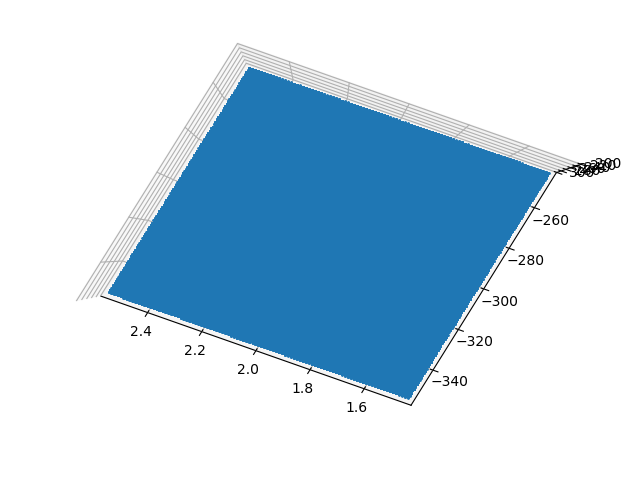

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(df_total[SourceFeatures.SOURCEHTAQNI], df_total[SourceFeatures.BIASDISCAQNV], df_total[SourceFeatures.SOLCEN_CURRENT], linestyle='', marker='o', markersize=1)
plt.show()

In [ ]:
cluster_performance_dbi(values_scaled, optigrid.clusters, optigrid.num_clusters)

In [ ]:
def silhouette_coefficient(a, b):
    if a < b:
        return 1 - a/b
    elif a == b:
        return 0
    else:
        return b/a - 1
    
def cluster_performance_silhouette(df_total, values_scaled, clusters, source_stability, voltage_breakdown_selection, num_clusters):
    mean_distances = np.array([np.array([np.sum(np.linalg.norm(values_scaled[cluster]-x, axis=1)) / len(cluster) for cluster in clusters]) for x in values_scaled])
    optigrid_cluster = df_total.loc[source_stability & voltage_breakdown_selection, 'optigrid_cluster']
    selector = np.ones((len(values_scaled), num_clusters), dtype=bool)
    selector[range(len(values)), optigrid_cluster] = False
    print(mean_distances)
    print(optigrid_cluster)
    print(selector)
    print(np.ma.masked_array(mean_distances, ~selector))
    df_total.loc[source_stability & voltage_breakdown_selection, 'mean_dist_same_cluster'] = np.amin(np.ma.masked_array(mean_distances, selector), axis=1)
    df_total.loc[source_stability & voltage_breakdown_selection, 'min_mean_dist_different_cluster'] = np.amin(np.ma.masked_array(mean_distances, ~selector), axis=1)
    df_total.loc[source_stability & voltage_breakdown_selection, 'silhouette'] = np.vectorize(silhouette_coefficient)(df_total.loc[source_stability & voltage_breakdown_selection, 'mean_dist_same_cluster'], df_total.loc[source_stability & voltage_breakdown_selection, 'min_mean_dist_different_cluster'])

In [ ]:
def all_pairs_euclid_squared_numpy(A, B):
    sqrA = np.broadcast_to(np.sum(np.power(A, 2), 1).reshape(A.shape[0], 1), (A.shape[0], B.shape[0]))
    sqrB = np.broadcast_to(np.sum(np.power(B, 2), 1).reshape(B.shape[0], 1), (B.shape[0], A.shape[0])).transpose()

    return sqrA - 2*np.matmul(A, B.transpose()) + sqrB

def cluster_performance_dbi(values_scaled, clusters, num_clusters):
    print("values_scaled: {}".format(values_scaled))
    values_per_cluster = [np.take(values_scaled, c, axis=0) for c in clusters]
    means = np.array([np.mean(c, axis=0) for c in values_per_cluster])
    print("values_per_cluster: {}".format(values_per_cluster[0][:10]))
    print("means: {}".format(means))
    assigned_cluster_mean = np.zeros((len(values_scaled), len(values_scaled[0])))
    for i, c in enumerate(clusters):
        assigned_cluster_mean[c] = means[i]
    print("assigned_cluster_mean: {}".format(assigned_cluster_mean))
        
    dists_from_means = np.linalg.norm(values_scaled-assigned_cluster_mean, axis=1)
    print("dists_from_means: {}".format([dists_from_means[c] for c in clusters]))
    s = np.array([np.sqrt(1./len(c) * np.sum(dists_from_means[c])) for c in clusters])
    print("s: {}".format(s))
    
    dists_between_clusters = all_pairs_euclid_squared_numpy(means, means)
    np.fill_diagonal(dists_between_clusters, np.nan)
    print("dists_between_clusters: {}".format(dists_between_clusters))
    
    r = np.tile(s, (num_clusters, 1))
    r = (r + r.T) / dists_between_clusters
    print("r: {}".format(r))
    d = np.nanmax(r, axis=1)
    dbi = np.mean(d)
    print("Davies-Bouldin index per cluster: {}".format(d))
    print("Davies-Bouldin index total: {}".format(dbi))

In [ ]:
def describe_clusters(optigrid, data, parameters):
    values = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    result = pd.DataFrame(columns = pd.MultiIndex.from_tuples([(p, v) for p in parameters for v in values] + [('DENSITY', 'count'), ('DENSITY', 'percentage')]))
    result.index.name = 'OPTIGRID_CLUSTER'
    
    for i, cluster in enumerate(optigrid.clusters):
        cluster_data = np.take(data, cluster, axis=0)
        mean = np.mean(cluster_data, axis=0)
        std = np.std(cluster_data, axis=0)
        quantiles = np.quantile(cluster_data, [0, 0.25, 0.5, 0.75, 1], axis=0)
        cluster_description = [[mean[i], std[i], quantiles[0][i], quantiles[1][i], quantiles[2][i], quantiles[3][i], quantiles[4][i]] for i in range(len(parameters))]
        cluster_description = [item for sublist in cluster_description for item in sublist]
        cluster_description.append(len(cluster))
        cluster_description.append(len(cluster)/len(data)*100)
        result.loc[i] = cluster_description
    return result

described = describe_clusters(optigrid, data, parameters)

In [ ]:
pd.set_option('display.max_columns', 500)
wanted_statistics = [[(param, 'mean'), (param, 'std')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist] + [('DENSITY', 'percentage')]

num_of_clusters_to_print = 10
described.sort_values(by=[('DENSITY', 'percentage')], ascending=False, inplace = True)
print("Sum of densities of printed clusters: {:.1f}%".format(described.head(n=num_of_clusters_to_print)[('DENSITY', 'percentage')].sum()))
described.head(n=num_of_clusters_to_print)[wanted_statistics].round(3)

For visualizing the clusters we will plot the densities of the parameters. For comparability we will use explicit ranges for the x-axis per parameter. Those ranges should be chosen beforehand by an expert to validate or falsify his intuition.

In [ ]:
num_clusters = 6 # number of clusters to visualize
data = df[parameters].values # We select the unscaled data again, because by clustering we did not change any ordering and this data corresponds to the real world
num_datapoints = len(data)

resolution = 200
bandwidth = [1, 0.01, 1, 10, 0.1, 0.001]
num_kde_samples = 40000

parameter_ranges = [[0,0] for i in range(len(parameters))]
parameter_ranges[0] = [-300, -200] # Biasdisc x-axis

parameter_ranges[1] = [5.1, 5.3] # Gas x-axis
#parameter_ranges[2] = [0, 3] # High voltage current x-axis
parameter_ranges[2] = [200, 300] # SolCen current x-axis
#parameter_ranges[3] = [900, 2100] # Forwardpower x-axis
parameter_ranges[3] = [1200, 1300] # SolExt current x-axis
parameter_ranges[4] = [5, 20] # Oven1 power x-axis
parameter_ranges[5] = [0, 0.05] # BCT25 current x-axis

best_clusters = sorted(optigrid.clusters, key=lambda x: len(x), reverse=True)
for i, cluster in enumerate(best_clusters[:num_clusters]):
    median = [described.iloc[i,described.columns.get_loc((param, '50%'))] for param in parameters]
    plot_cluster(data, cluster, parameters, parameter_ranges, resolution=resolution, median=median, bandwidth=bandwidth, percentage_of_values=1, num_kde_samples=num_kde_samples)

Now, we want to find all high voltage breakdowns that correspond to the currently considered source stability, and find out to which cluster each datapoint belongs.

In [ ]:
wanted_statistics.append(('num_of_breakdowns', ''))
described.head(n=num_of_clusters_to_print)[wanted_statistics].round(3)

In [ ]:
wanted_statistics = [[(param, 'mean')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist] + [('num_of_breakdowns', '')]
corr_described = described[wanted_statistics].corr()
corr_described.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [ ]:
pd.set_option('display.max_columns', 500)
wanted_statistics = [[(param, 'mean'), (param, 'std'),  (param, 'min'),  (param, 'max')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist]
df_breakdowns.groupby('is_breakdown').describe()[wanted_statistics].round(2)

In [ ]:
import numpy as np

def d(x,y):
    return np.linalg.norm(x-y)

size = 10
data = np.random.uniform(0, 1, (size, 1))
data

In [ ]:
a = np.array([np.sum(np.linalg.norm(data-x, axis=1)) for x in data]) / (size - 1)
a

In [ ]:
import pandas as pd
import numpy as np

values = [0, 2, 2, 2, 3, 3, 1]
values = np.array([[x, x] for x in values])
clusters = [[0, 6], [1, 2, 3], [4, 5]]

values, clusters

In [ ]:
cluster_performance_dbi(values, clusters, len(clusters))

In [ ]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(values, [0, 1, 1, 1, 2, 2, 0])

In [ ]:
source_stable = 1
print("Starting clustering for source stability {}".format(source_stable))
source_stability = df_total['source_stable'] == source_stable
voltage_breakdown_selection = df_total['is_breakdown'] > 0

values = select_values(df_total, parameters, source_stability, ~voltage_breakdown_selection) # First, get the data without breakdowns,
scaler, values_scaled = scale_values(values, None) # standard scale it
print(values_scaled)
optigrid = run_optigrid(values_scaled, optigrid_params) # and compute the clusters.
print(values_scaled)
#assign_clusters_df_total(df_total, optigrid, len(values), source_stability, ~voltage_breakdown_selection) # Then, assign the found clusters to the original dataframe in a new column 'optigrid_clusters'
print("Calculating cluster performance cluster performance")
#cluster_performance_silhouette(df_total, values_scaled, optigrid.clusters, source_stability, voltage_breakdown_selection, optigrid.num_clusters)